# (1) Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 500)

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')

In [3]:
from nltk import word_tokenize

columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

def load_df(path, d_type, header):
    df = pd.read_csv(path, header=header, sep = "\t")
    if len(df.columns) == len(columns):
        df.columns = columns
    if d_type == 'word':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))<=1,]
    elif d_type == 'phrase':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))>1,]
    return df

def load_datasets(names, train_name, test_name, type_train = None, type_test = None, header=None):
    MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
    datasets = [Dataset(name, load_df(MAIN_PATH_DATASET + name + '_' + train_name + '.tsv', type_train, header),
                              load_df(MAIN_PATH_DATASET + name + '_' + test_name + '.tsv', type_test, header))
                              for name in names]
    return datasets

# (2) Preprocessing

In [4]:
from nltk.stem.wordnet import *
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys

wordNetLemmatizer = WordNetLemmatizer()

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

def ratio_non_alpha(target):
    return 1 - (np.sum([1 for letter in target if (ord(letter)>=65 and ord(letter)<=90) 
             or (ord(letter)>=97 and ord(letter)<=122)]) / len(target))

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, target, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results 
                        if remove_punctuation(result).strip() and result != 'POS']
    if len(nltk.word_tokenize(target)) != len(filtered_results):
            return ['n' for word in target.split()]
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    #tokens = nltk.word_tokenize(target)
    tokens = target.split()
    if pos:
        if len(pos) != len(tokens):
            return target
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'target', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos] 
                                          if pos else [])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

In [5]:
def preprocess_datasets(datasets):
    return [Dataset(ds.name, preprocessing(ds.train), 
                             preprocessing(ds.test)) 
                             for ds in datasets]

In [161]:
def extract_stats_from_df(dataframe):
    rows = dataframe.shape[0]
    num_sents = len(dataframe.sentence.unique())
    num_nc = dataframe.groupby('binary').size()[0]
    num_c = dataframe.groupby('binary').size()[1]
    c_ratio = num_c / (num_c + num_nc)
    return rows, num_sents, num_nc, num_c, c_ratio
    
def extract_overlapping_num(dataframe1, dataframe2):
    words1 = set([word for val in dataframe1.p_target.values for word in val.split()])
    words2 = set([word for val in dataframe2.p_target.values for word in val.split()])
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    return len(intersection) / len(union)

def extract_stats_for_datasets(datasets):
    for ds in datasets:
        print(ds.name)
        rows, num_sents, num_nc, num_c, c_ratio = extract_stats_from_df(ds.train)
        print('Training : #rows : {}, #sent. : {}, #c : {}, c_ratio : {}'.format(rows, num_sents, num_c, c_ratio))
        rows, num_sents, num_nc, num_c, c_ratio = extract_stats_from_df(ds.test)
        print('Testing : #rows : {}, #sent. : {}, #c : {}, c_ratio : {}'.format(rows, num_sents, num_c, c_ratio))

def extract_overlapping_datasets(datasets_dev, datasets_test):
    for index, ds in enumerate(datasets_dev):
        print(ds.name)
        print('OL Train-to-Train : {}'.format(extract_overlapping_num(ds.train, ds.train)))
        print('OL Train-to-Dev : {}'.format(extract_overlapping_num(ds.train, ds.test)))
        print('OL Train-to-Test : {}'.format(extract_overlapping_num(ds.train, datasets_test[index].test)))

# (3.1) DS-W

In [163]:
datasets_w_train_dev = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='word', type_test='word')
datasets_w_train_dev = preprocess_datasets(datasets_w_train_dev)

datasets_w_train_test = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Test', type_train='word', type_test='word')
datasets_w_train_test= preprocess_datasets(datasets_w_train_test)

In [164]:
print('-----------------------------------------------------------')
print('Training and Dev')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_w_train_dev)
print('-----------------------------------------------------------')
print('Training and Test')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_w_train_test)
print('-----------------------------------------------------------')
extract_overlapping_datasets(datasets_w_train_dev, datasets_w_train_test)

-----------------------------------------------------------
Training and Dev
-----------------------------------------------------------
Wikipedia
Training : #rows : 4833, #sent. : 387, #c : 1911, c_ratio : 0.3954065797641217
Testing : #rows : 606, #sent. : 53, #c : 265, c_ratio : 0.4372937293729373
WikiNews
Training : #rows : 6779, #sent. : 653, #c : 2492, c_ratio : 0.367605841569553
Testing : #rows : 776, #sent. : 85, #c : 281, c_ratio : 0.36211340206185566
News
Training : #rows : 11944, #sent. : 946, #c : 3887, c_ratio : 0.32543536503683856
Testing : #rows : 1502, #sent. : 128, #c : 490, c_ratio : 0.3262316910785619
-----------------------------------------------------------
Training and Test
-----------------------------------------------------------
Wikipedia
Training : #rows : 4833, #sent. : 387, #c : 1911, c_ratio : 0.3954065797641217
Testing : #rows : 750, #sent. : 61, #c : 341, c_ratio : 0.45466666666666666
WikiNews
Training : #rows : 6779, #sent. : 653, #c : 2492, c_ratio : 0

# (3.2) DS-P

In [165]:
datasets_p_train_dev = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='phrase', type_test='phrase')
datasets_p_train_dev = preprocess_datasets(datasets_p_train_dev)

datasets_p_train_test = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Test', type_train='phrase', type_test='phrase')
datasets_p_train_test= preprocess_datasets(datasets_p_train_test)

In [166]:
print('-----------------------------------------------------------')
print('Training and Dev')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_p_train_dev)
print('-----------------------------------------------------------')
print('Training and Test')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_p_train_test)
print('-----------------------------------------------------------')
extract_overlapping_datasets(datasets_p_train_dev, datasets_p_train_test)

-----------------------------------------------------------
Training and Dev
-----------------------------------------------------------
Wikipedia
Training : #rows : 718, #sent. : 320, #c : 583, c_ratio : 0.8119777158774373
Testing : #rows : 88, #sent. : 38, #c : 74, c_ratio : 0.8409090909090909
WikiNews
Training : #rows : 967, #sent. : 445, #c : 724, c_ratio : 0.7487073422957601
Testing : #rows : 94, #sent. : 49, #c : 72, c_ratio : 0.7659574468085106
News
Training : #rows : 2058, #sent. : 758, #c : 1656, c_ratio : 0.8046647230320699
Testing : #rows : 262, #sent. : 101, #c : 206, c_ratio : 0.7862595419847328
-----------------------------------------------------------
Training and Test
-----------------------------------------------------------
Wikipedia
Training : #rows : 718, #sent. : 320, #c : 583, c_ratio : 0.8119777158774373
Testing : #rows : 120, #sent. : 48, #c : 98, c_ratio : 0.8166666666666667
WikiNews
Training : #rows : 967, #sent. : 445, #c : 724, c_ratio : 0.7487073422957601

In [137]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

def plot_phrase_length_distribution(train, test, name):
    train_test = train.append(test)
    train_test['phrase_length'] = train_test.target.apply(lambda val : len(word_tokenize(val)))

    
    sns.set(style="darkgrid", palette="GnBu_d")
    ax1 = sns.countplot(x="phrase_length", hue="binary", data=train_test)
    handles, _ = ax1.get_legend_handles_labels()
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.yaxis.label.set_size(18)
    ax1.xaxis.label.set_size(18)
    ax1.legend(handles, ["non-complex", "complex"], title='$\\bf{Class}$')
    #ax1.legend_.set_size(18)
    ax1.figure.set_size_inches(7, 5.5)
    ax1.set_title('$\\bf{'+name+'}$')
    plt.tight_layout()
    plt.show(ax1)
    figure = ax1.get_figure()
    figure.savefig('../plots/{}_phrase_dist.png'.format(name), dpi=900)

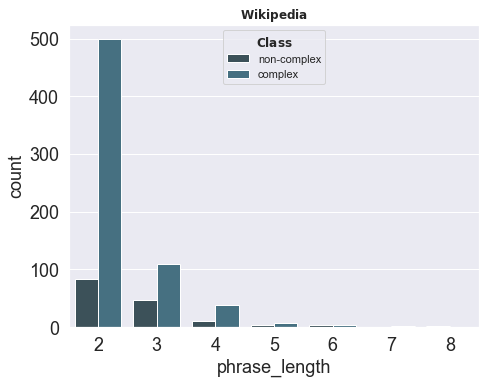

In [138]:
# Wikipedia 
plot_phrase_length_distribution(datasets_p_train_dev[0].train, datasets_p_train_dev[0].test, 'Wikipedia')

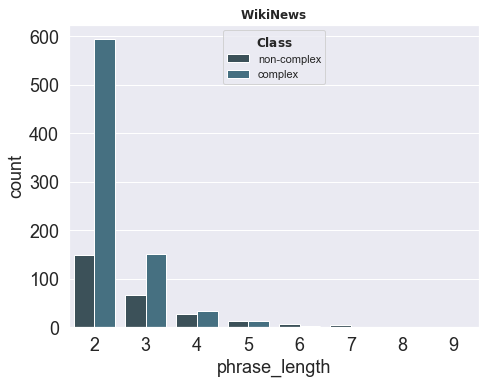

In [139]:
# WikiNews
plot_phrase_length_distribution(datasets_p_train_dev[1].train, datasets_p_train_dev[1].test, 'WikiNews')

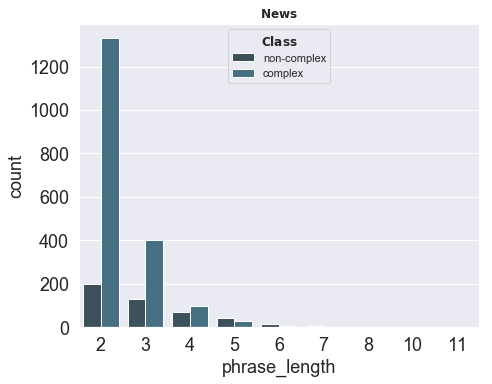

In [140]:
#News
plot_phrase_length_distribution(datasets_p_train_dev[2].train, datasets_p_train_dev[2].test, 'News')

# (3.3) DS-WP

In [167]:
datasets_wp_train_dev = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='both', type_test='both')
datasets_wp_train_dev = preprocess_datasets(datasets_wp_train_dev)

datasets_wp_train_test = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Test', type_train='both', type_test='both')
datasets_wp_train_test= preprocess_datasets(datasets_wp_train_test)

In [168]:
print('-----------------------------------------------------------')
print('Training and Dev')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_wp_train_dev)
print('-----------------------------------------------------------')
print('Training and Test')
print('-----------------------------------------------------------')
extract_stats_for_datasets(datasets_wp_train_test)
print('-----------------------------------------------------------')
extract_overlapping_datasets(datasets_wp_train_dev, datasets_wp_train_test)

-----------------------------------------------------------
Training and Dev
-----------------------------------------------------------
Wikipedia
Training : #rows : 5551, #sent. : 387, #c : 2494, c_ratio : 0.44928841650153123
Testing : #rows : 694, #sent. : 53, #c : 339, c_ratio : 0.4884726224783862
WikiNews
Training : #rows : 7746, #sent. : 653, #c : 3216, c_ratio : 0.41518202943454685
Testing : #rows : 870, #sent. : 85, #c : 353, c_ratio : 0.4057471264367816
News
Training : #rows : 14002, #sent. : 948, #c : 5543, c_ratio : 0.3958720182831024
Testing : #rows : 1764, #sent. : 128, #c : 696, c_ratio : 0.3945578231292517
-----------------------------------------------------------
Training and Test
-----------------------------------------------------------
Wikipedia
Training : #rows : 5551, #sent. : 387, #c : 2494, c_ratio : 0.44928841650153123
Testing : #rows : 870, #sent. : 61, #c : 439, c_ratio : 0.5045977011494253
WikiNews
Training : #rows : 7746, #sent. : 653, #c : 3216, c_ratio : 